# Gated Recurrent Units

- LSTMs are pretty slow/expensive to compute. Gated recurrent units arose from a desire by researchers to keep the idea of an internal state, while speeding up the computation. GRUs often achieve similar/comparable performance, but with improved computational efficiency.

## Reset Gate and Update Gate

- In a GRU, the three gates of an LSTM are replaced by just two, the _reset gate_ and the _update gate_. These are highly similar to the gates of an LSTM, the reset gate determines how much of the old state is forgotten, while the update gate allows us to know how much of the new state is copied from the old one (??? don't these two statements sort of mean the same thing: revise.)

The reset $\mathbf{R}$ and update $\mathbf{Z}$ gates are given by the following esxpressions

$$\mathbf{R}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xr} + \mathbf{H}_{t-1}\mathbf{W}_{hr} + \mathbf{b}_r)$$
$$\mathbf{Z}_t = \sigma(\mathbf{X}_t\mathbf{W}_{xz} + \mathbf{H}_{t-1}\mathbf{W}_{hz} + \mathbf{b}_z)$$

The reset gate is integrated into the regular update mechanism for an RNN to determine how much of the previous timestep's hidden state is preserved

$$\mathbf{\tilde{H}} = tanh(\mathbf{X}_t\mathbf{W}_{xh} + (\mathbf{R}_t \odot \mathbf{H}_{t-1})\mathbf{W}_{hh} + \mathbf{b}_h) $$

The value $\mathbf{\tilde{H}}$ is termed the _candidate_ hidden state, because the effect of the update gate has yet to be take into account. We incorporate the update gate in such a way that when its values are close to 1 (that is, the new hidden state is similar to the existing hidden state) we do not update the hidden state weights, essentially ignoring the information in X. When the value of Z is close to 0 (i.e. the candidate state and the latent state are very different) we do update the hidden state.

$$ \mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1} + (\mathbf{Z}_t - 1) \mathbf{\tilde{H}}_t$$

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# IMplementation from scratch

class GRUScratch(d2l.Module):
    
    def __init__(self, num_inputs, num_hiddens, sigma= 0.01):

        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        triple = lambda: (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(self.num_hiddens))
        )

        self.W_xr, self.W_hr, self.b_r = triple()
        self.W_xz, self.W_hz, self.b_z = triple()
        self.W_xh, self.W_hh, self.b_h = triple()

    def forward(self, inputs, H=None):
        if H is None:
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        outputs = []
        for X in inputs:
            R = torch.sigmoid(
                torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r
            )
            Z = torch.sigmoid(
                torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z
            )
            H_tilde = torch.tanh(
                torch.matmul(X, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h
            )
            H = Z * H + (1-Z) * H_tilde
            outputs.append(H)
        return outputs, H


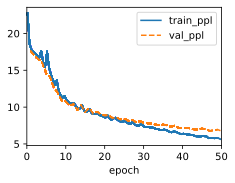

In [3]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [4]:
# of course... there's also as always a trivially straightforward way to implement this with pytorch

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

    

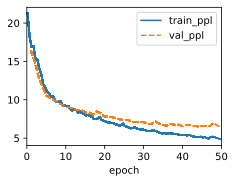

In [5]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [8]:
model.predict('it has', 50, data.vocab, d2l.try_gpu())

'it has the time traveller the time traveller the time tr'

GRUS are generally lighterweight than LSTMs, while retaining most of the performance benefits. Essentially classical RNNs in the extreme case of the reset gate being entirely turned on, and can skip subsequences by engaging the update gate (i.e. to stop updating the internal state when desired. )